In [1]:
import torch
import torchaudio
import librosa

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

N_FFT = 1 << 14 # 2^14

new_sr = 16000
nyquist = new_sr / 2
F_MIN = 27.5
BINS_PER_OCTAVE = 96
HOP_LENGTH = N_FFT // 2

n_octaves = np.log2(nyquist / F_MIN) - 0.1
N_BINS = int(n_octaves * BINS_PER_OCTAVE)
print(f"Number of CQT Bins: {N_BINS}")

F_RANGE = [200, 6000]


def get_stft(waveform, hop_length):
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)
    stft_transformer = torchaudio.transforms.Spectrogram(n_fft=N_FFT, power=2, hop_length=hop_length)
    stft = stft_transformer(waveform).numpy()
    stft = 10 * np.log10(np.clip(stft, 1e-10, 1e6))
    return stft


def get_cqt(waveform, sr, n_bins, bins_per_octave, f_min, hop_length):
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)
    cqt = librosa.cqt(
        y=waveform.numpy(),
        sr=sr,
        hop_length=hop_length,
        n_bins=n_bins,
        bins_per_octave=bins_per_octave,
        fmin=f_min,
    )
    cqt = np.abs(cqt)
    cqt = 10 * np.log10(np.clip(cqt, 1e-10, 1e6))
    if cqt.ndim == 2:
        cqt = cqt[np.newaxis, :, :]
    return cqt


def lower_hull(x, area=10):
    idx, hull = [], []
    for i in range(len(x)-area+1):
        patch = x[i:i+area]
        rel_idx = np.argmin(patch)
        abs_idx = rel_idx + i
        if abs_idx not in idx:
            idx.append(abs_idx)
            hull.append(patch[rel_idx])
    
    if len(idx) < 2:
        return np.array([0, len(x)-1]), np.array([x[0], x[-1]])

    if idx[0] != 0:
        idx.insert(0, 0); hull.insert(0, x[0])
    if idx[-1] != len(x)-1:
        idx.append(len(x)-1); hull.append(x[-1])
    return np.array(idx), np.array(hull)


def get_fakeprint(stft, sr, f_range=[5000, 16000]):
    fp = np.mean(stft, axis=(0, 2))
    x_real = np.linspace(0, sr / 2, num=len(fp))
    actual_fmax = min(f_range[1], sr // 2)
    mask = (x_real >= f_range[0]) & (x_real <= actual_fmax)
    
    x_crop = x_real[mask]
    fp_crop = fp[mask]
    
    lower_x, lower_c = lower_hull(fp_crop, area=10)
    low_hull_curve = interpolate.interp1d(x_crop[lower_x], lower_c, kind="quadratic")(x_crop)
    
    residue = np.clip(fp_crop - low_hull_curve, 0, None)
    residue = residue / (1e-6 + np.max(residue))
    
    return x_crop, residue


def get_fakeprint_cqt(cqt_data, sr, f_min, bins_per_octave, f_range=[5000, 16000]):

    if isinstance(cqt_data, torch.Tensor):
        cqt_data = cqt_data.detach().cpu().numpy()
    
    # Average across channels (dim 0) and time (dim 2)
    # Shape transition: (2, 84, 12608) -> (84,)
    fp = np.mean(cqt_data, axis=(0, 2))
    
    # generate the Logarithmic Frequency Axis
    bin_indices = np.arange(len(fp))
    x_real = f_min * (2 ** (bin_indices / bins_per_octave))
    
    actual_fmax = min(f_range[1], sr // 2)
    mask = (x_real >= f_range[0]) & (x_real <= actual_fmax)

    x_crop = x_real[mask]
    fp_crop = fp[mask]
    
    lower_idx, lower_vals = lower_hull(fp_crop, area=10)
    
    interp_func = interpolate.interp1d(x_crop[lower_idx], lower_vals, kind="quadratic")
    low_hull_curve = interp_func(x_crop)
    
    residue = np.clip(fp_crop - low_hull_curve, 0, None)
    residue = residue / (1e-6 + np.max(residue))
    
    return x_crop, residue

Number of CQT Bins: 776


In [2]:
PLOT_AI = True

if PLOT_AI:
    file_path = "data/ai/fake_00001_suno_0.mp3"
    ps_m05_file_path = "attack/pitch_shift/ps_-0.5/fake_00001_suno_0.mp3"
    ps_05_file_path = "attack/pitch_shift/ps_0.5/fake_00001_suno_0.mp3"
else:
    file_path = "data/human/Young-Love-Love-On-The-Run.mp3"
    ps_m05_file_path = "attack/pitch_shift_human/ps_-0.5/Young-Love-Love-On-The-Run.mp3"
    ps_05_file_path = "attack/pitch_shift_human/ps_0.5/Young-Love-Love-On-The-Run.mp3"

waveform, sr = torchaudio.load(file_path)
ps_m05_waveform, sr = torchaudio.load(ps_m05_file_path)
ps_05_waveform, sr = torchaudio.load(ps_05_file_path)

if sr != new_sr:
    waveform = torchaudio.transforms.Resample(sr, new_sr)(waveform)
    ps_m05_waveform = torchaudio.transforms.Resample(sr, new_sr)(ps_m05_waveform)
    ps_05_waveform = torchaudio.transforms.Resample(sr, new_sr)(ps_05_waveform)
    sr = new_sr

print(f"Waveform Shape: {waveform.shape}")
print(f"Pitch-Shifted (-0.5) Waveform Shape: {ps_m05_waveform.shape}")
print(f"Pitch-Shifted (0.5) Waveform Shape: {ps_05_waveform.shape}")
print(f"Sample Rate: {sr}")

cqt = get_cqt(waveform, sr, N_BINS, BINS_PER_OCTAVE, F_MIN, hop_length=HOP_LENGTH)
ps_m05_cqt = get_cqt(ps_m05_waveform, sr, N_BINS, BINS_PER_OCTAVE, F_MIN, hop_length=HOP_LENGTH)
ps_05_cqt = get_cqt(ps_05_waveform, sr, N_BINS, BINS_PER_OCTAVE, F_MIN, hop_length=HOP_LENGTH)

stft = get_stft(waveform, hop_length=HOP_LENGTH)
ps_m05_stft = get_stft(ps_m05_waveform, hop_length=HOP_LENGTH)
ps_05_stft = get_stft(ps_05_waveform, hop_length=HOP_LENGTH)

print(f"CQT Shape: {cqt.shape}")
print(f"STFT Shape: {stft.shape}")

x, res = get_fakeprint_cqt(cqt_data=cqt, sr=sr, f_min=F_MIN, bins_per_octave=BINS_PER_OCTAVE, f_range=F_RANGE)
x_ps_m05, res_ps_m05 = get_fakeprint_cqt(cqt_data=ps_m05_cqt, sr=sr, f_min=F_MIN, bins_per_octave=BINS_PER_OCTAVE, f_range=F_RANGE)
x_ps_05, res_ps_05 = get_fakeprint_cqt(cqt_data=ps_05_cqt, sr=sr, f_min=F_MIN, bins_per_octave=BINS_PER_OCTAVE, f_range=F_RANGE)

x_stft, res_stft = get_fakeprint(stft, sr, f_range=F_RANGE)
x_ps_m05_stft, res_ps_m05_stft = get_fakeprint(ps_m05_stft, sr, f_range=F_RANGE)
x_ps_05_stft, res_ps_05_stft = get_fakeprint(ps_05_stft, sr, f_range=F_RANGE)

print(f"CQT Fakeprint Shape: {res.shape}")
print(f"STFT Fakeprint Shape: {res_stft.shape}")

Waveform Shape: torch.Size([1, 3584000])
Pitch-Shifted (-0.5) Waveform Shape: torch.Size([1, 3584000])
Pitch-Shifted (0.5) Waveform Shape: torch.Size([1, 3584000])
Sample Rate: 16000


/Users/emiledugelay/Machine-Learning/deezer/robust-deepfake-detector/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CQT Shape: (1, 776, 438)
STFT Shape: (1, 8193, 438)
CQT Fakeprint Shape: (471,)
STFT Fakeprint Shape: (5940,)


In [3]:
def get_2d_fakeprint_cqt(cqt_data, sr, f_min, bins_per_octave=12, f_range=[100, 6000]):
    """
    Computes a 2D 'fakeprint' by removing the spectral floor (lower hull) 
    from each time frame of the CQT.
    """
    if isinstance(cqt_data, torch.Tensor):
        cqt_data = cqt_data.detach().cpu().numpy()
    
    # 1. Handle Channels: Average across channels if stereo
    # Shape transition: (Channels, Bins, Time) -> (Bins, Time)
    if cqt_data.ndim == 3:
        fp_2d = np.mean(cqt_data, axis=0)
    else:
        fp_2d = cqt_data

    # 2. Generate the Logarithmic Frequency Axis for cropping
    num_bins, num_frames = fp_2d.shape
    bin_indices = np.arange(num_bins)
    x_real = f_min * (2 ** (bin_indices / bins_per_octave))
    
    actual_fmax = min(f_range[1], sr // 2)
    mask = (x_real >= f_range[0]) & (x_real <= actual_fmax)

    # Crop the frequency axis and the data
    x_crop = x_real[mask]
    fp_2d_crop = fp_2d[mask, :]  # Shape: (Cropped_Bins, Time)
    
    # 3. Process each time frame
    # We initialize an empty array for the residue
    residue_2d = np.zeros_like(fp_2d_crop)
    
    # Pre-calculate hull parameters
    area_param = min(len(x_crop) // 4, 10)

    for t in range(num_frames):
        frame_data = fp_2d_crop[:, t]
        
        # Calculate lower hull for this specific frame
        lower_idx, lower_vals = lower_hull(frame_data, area=area_param)
        
        # Interpolate the background floor
        interp_func = interpolate.interp1d(
            x_crop[lower_idx], lower_vals, kind="quadratic", fill_value="extrapolate"
        )
        low_hull_curve = interp_func(x_crop)
        
        # Calculate residue (signal above the floor)
        frame_residue = np.clip(frame_data - low_hull_curve, 0, None)
        
        # Normalize the frame residue
        max_val = np.max(frame_residue)
        residue_2d[:, t] = frame_residue / (1e-6 + max_val)
    
    return x_crop, residue_2d

In [4]:
# x_crop, residue_2d = get_2d_fakeprint_cqt(cqt, sr, F_MIN, BINS_PER_OCTAVE, f_range=[100, 6000])
# print(f"x_crop: {x_crop.min()} to {x_crop.max()}")
# print(f"CQT 2D Fakeprint Shape: {residue_2d.shape}")

# from torch.nn import functional as F
# tensor_2d = torch.from_numpy(residue_2d).unsqueeze(0).unsqueeze(0)
# resized_tensor = F.interpolate(tensor_2d, size=(512, 512), mode='bilinear', align_corners=False)
# residue_512 = resized_tensor.squeeze().numpy()
# print(f"Resized 2D Fakeprint Shape: {residue_512.shape}")

# plt.figure(figsize=(10, 8))
# plt.imshow(residue_2d, aspect='auto', origin='lower')
# plt.title("2D Fakeprint (Residue Over Time)")
# plt.colorbar()
# plt.show()

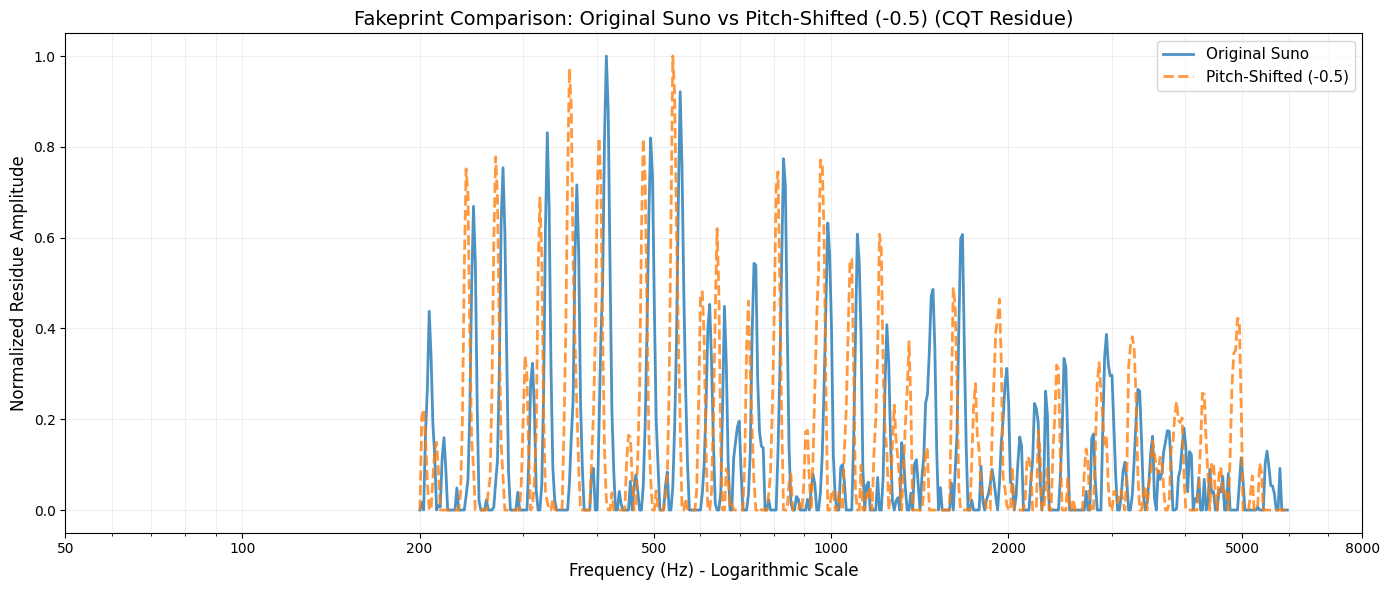

In [5]:
import matplotlib.ticker as ticker

def plot_fakeprint_comparison(x1, res1, x2, res2, x3, res3, label1="Original", label2="Pitch Shifted (-0.5)", label3="Pitch Shifted (0.5)"):
    plt.figure(figsize=(14, 6))
    
    # Plot Original
    plt.plot(x1, res1, label=label1, color='#1f77b4', linewidth=2, alpha=0.8)

    # # Plot Pitch-Shifted (-0.5)
    plt.plot(x2, res2, label=label2, color='#ff7f0e', linewidth=2, alpha=0.8, linestyle='--')
    
    # # Plot Pitch-Shifted (0.5)
    #plt.plot(x3, res3, label=label3, color='#2ca02c', linewidth=2, alpha=0.8, linestyle='-.')

    plt.xscale('log')
    
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.xticks([50, 100, 200, 500, 1000, 2000, 5000, 8000])
    
    plt.title(f"Fakeprint Comparison: {label1} vs {label2} (CQT Residue)", fontsize=14)
    plt.xlabel("Frequency (Hz) - Logarithmic Scale", fontsize=12)
    plt.ylabel("Normalized Residue Amplitude", fontsize=12)
    
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()

# Execute the plot
plot_fakeprint_comparison(x, res, x_ps_m05, res_ps_m05, x_ps_05, res_ps_05, label1="Original Suno", label2="Pitch-Shifted (-0.5)", label3="Pitch-Shifted (0.5)")

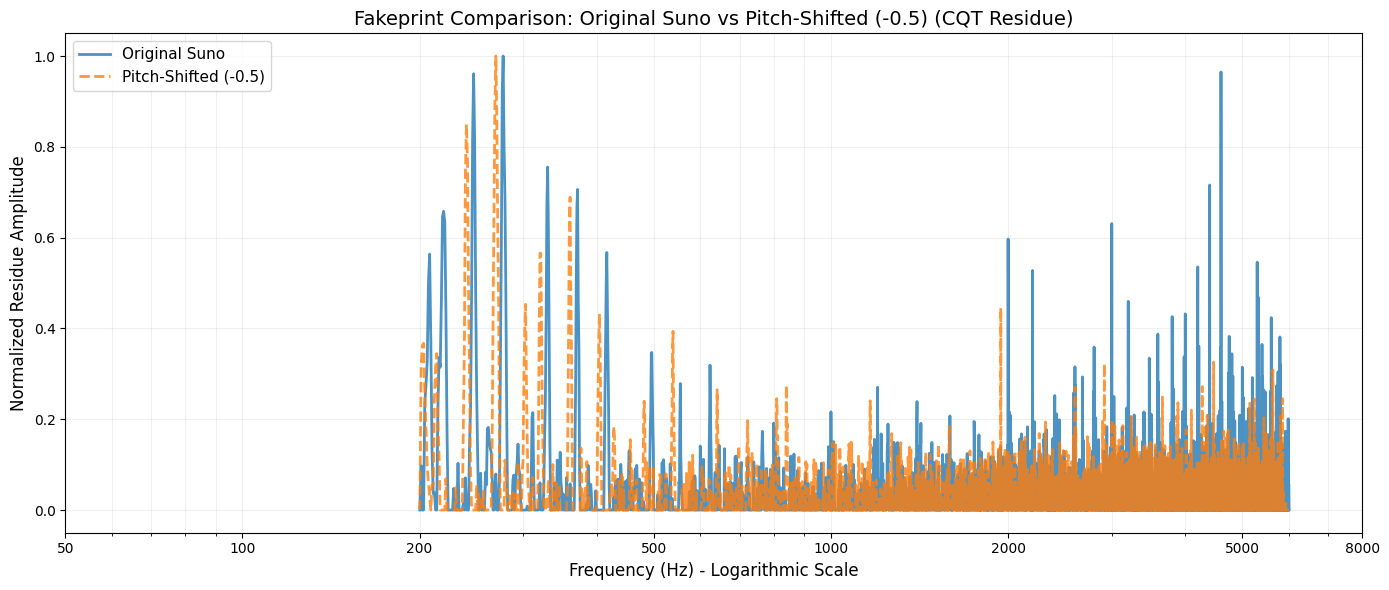

In [6]:
plot_fakeprint_comparison(x_stft, res_stft, x_ps_m05_stft, res_ps_m05_stft, x_ps_05_stft, res_ps_05_stft, label1="Original Suno", label2="Pitch-Shifted (-0.5)", label3="Pitch-Shifted (0.5)")

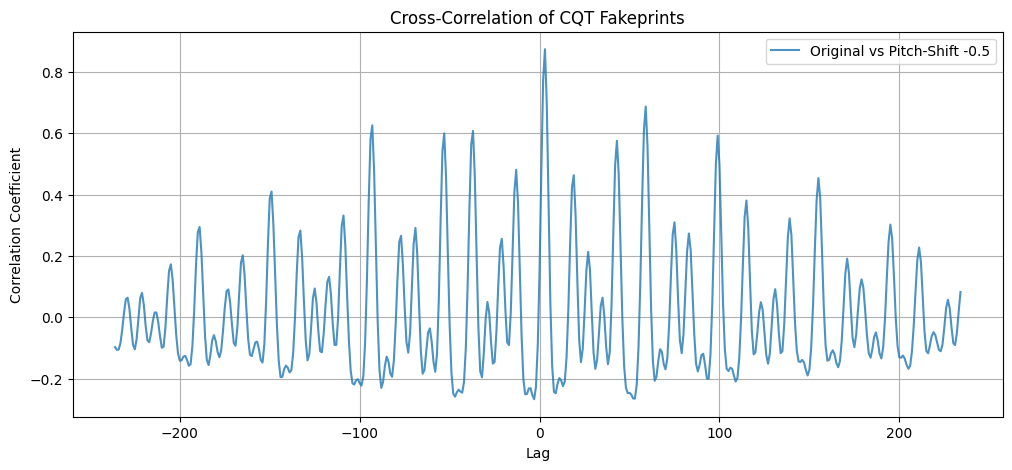

CQT Max Correlation (-0.5): 0.8745


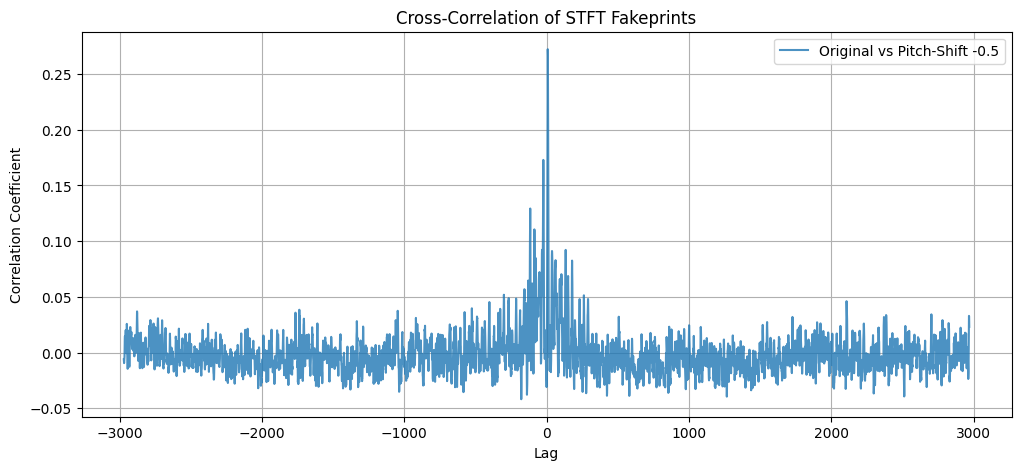

STFT Max Correlation (-0.5): 0.2722


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

def compute_and_plot_correlation(original, shifted_m05, title_prefix):
    # Flatten if they are 2D, as we want a global similarity score
    orig_flat = original.flatten()
    ps_m05_flat = shifted_m05.flatten()

    # Normalize to ensure correlation is between -1 and 1 (Pearson-like)
    orig_norm = (orig_flat - np.mean(orig_flat)) / (np.std(orig_flat) * len(orig_flat))
    ps_m05_norm = (ps_m05_flat - np.mean(ps_m05_flat)) / np.std(ps_m05_flat)

    # Compute Cross-Correlation
    corr_m05 = correlate(orig_norm, ps_m05_norm, mode='same')
    
    # Lags for the X-axis
    lags = np.arange(-len(corr_m05)//2, len(corr_m05)//2)

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(lags, corr_m05, label='Original vs Pitch-Shift -0.5', alpha=0.8)
    plt.title(f'Cross-Correlation of {title_prefix} Fakeprints')
    plt.xlabel('Lag')
    plt.ylabel('Correlation Coefficient')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"{title_prefix} Max Correlation (-0.5): {np.max(corr_m05):.4f}")

# Compute for CQT-based Fakeprints
compute_and_plot_correlation(res, res_ps_m05, "CQT")

# Compute for STFT-based Fakeprints
compute_and_plot_correlation(res_stft, res_ps_m05_stft, "STFT")